In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

import torch
from torchvision import models

import urllib.request

# For saving images
import sys
sys.path.append('../')

from utils.visualise import display_imagenet_output
from utils.datasets import preprocess_imagenet_image

## Load model and example image

(-0.5, 760.5, 760.5, -0.5)

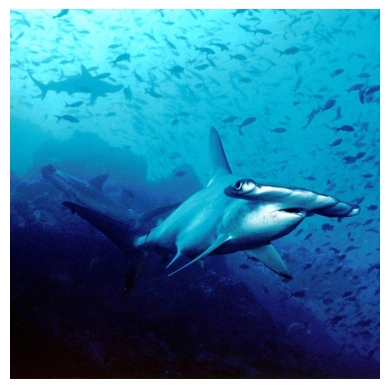

In [3]:
# Download example image
import sys
sys.path.append('../')

from utils.download import save_image

# Load alternative sample image from the web
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Hammerhead_shark%2C_Cocos_Island%2C_Costa_Rica.jpg/960px-Hammerhead_shark%2C_Cocos_Island%2C_Costa_Rica.jpg"
save_image(img_url, "sample_image.jpg",crop_to_square=False,resize=False)

img_path = "sample_image.jpg"
img = Image.open(img_path).convert("RGB")
img = img.crop((40, 0, 801, 761))

plt.imshow(img)
plt.axis("off")

Figure saved to /Users/conorosullivan/Documents/XAI/sample_image.pdf


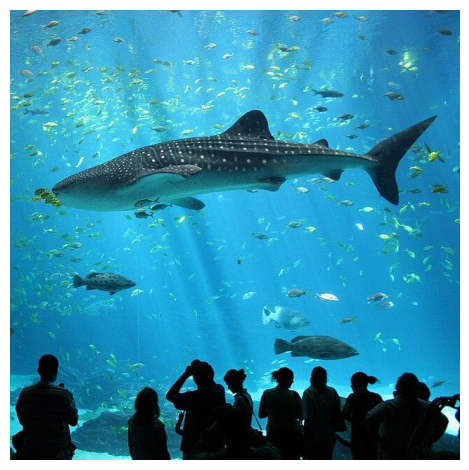

In [4]:
# Load a sample image from the web
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Male_whale_shark_at_Georgia_Aquarium.jpg/960px-Male_whale_shark_at_Georgia_Aquarium.jpg"
save_image(img_url, "sample_image.jpg",crop_to_square=False,resize=False)


img = Image.open(img_path).convert("RGB")
img = img.crop((320, 0, 960, 640))  # Crop to 640x640

plt.imshow(img)
plt.axis("off")

In [5]:
# Load the pre-trained model (e.g., VGG16)
model = models.vgg16(pretrained=True)

# Set the model to gpu
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# Preprocess the image
img_tensor = preprocess_imagenet_image(img_path)
img_tensor = img_tensor.to(device)

# Forward pass
predictions = model(img_tensor)
display_imagenet_output(predictions,n=5)

hammerhead 0.5713919997215271
tiger shark 0.2186235934495926
electric ray 0.09459890425205231
gar 0.03304899111390114
stingray 0.024704914540052414


tensor(4, device='mps:0')

## Pytorch hooks

In [7]:
# Replace all in-place ReLU activations with out-of-place ones
def replace_relu(model):

    for name, child in model.named_children():
        if isinstance(child, torch.nn.ReLU):
            setattr(model, name, torch.nn.ReLU(inplace=False))
            print(f"Replacing ReLU activation in layer: {name}")
        else:
            replace_relu(child)  # Recursively apply to submodules

# Apply the modification to the VGG16 model
replace_relu(model)

Replacing ReLU activation in layer: 1
Replacing ReLU activation in layer: 3
Replacing ReLU activation in layer: 6
Replacing ReLU activation in layer: 8
Replacing ReLU activation in layer: 11
Replacing ReLU activation in layer: 13
Replacing ReLU activation in layer: 15
Replacing ReLU activation in layer: 18
Replacing ReLU activation in layer: 20
Replacing ReLU activation in layer: 22
Replacing ReLU activation in layer: 25
Replacing ReLU activation in layer: 27
Replacing ReLU activation in layer: 29
Replacing ReLU activation in layer: 1
Replacing ReLU activation in layer: 4


In [8]:
# Dictionary to store activations
activations = []

# Function to save activations
def save_activations(module, input, output):
    activations.append(output.detach().cpu().numpy().squeeze())

# Attach the hook to the last convolutional layer
hook = model.features[28].register_forward_hook(save_activations)

# Forward pass through the model to get activations
prediction = model(img_tensor)

# Remove the hook after use
hook.remove()

In [9]:
act_shape = np.shape(activations[0])
print(f"Shape of activations: {act_shape}") # (512, 14, 14)

Shape of activations: (512, 14, 14)


Figure saved to /Users/conorosullivan/Documents/XAI/activations.pdf


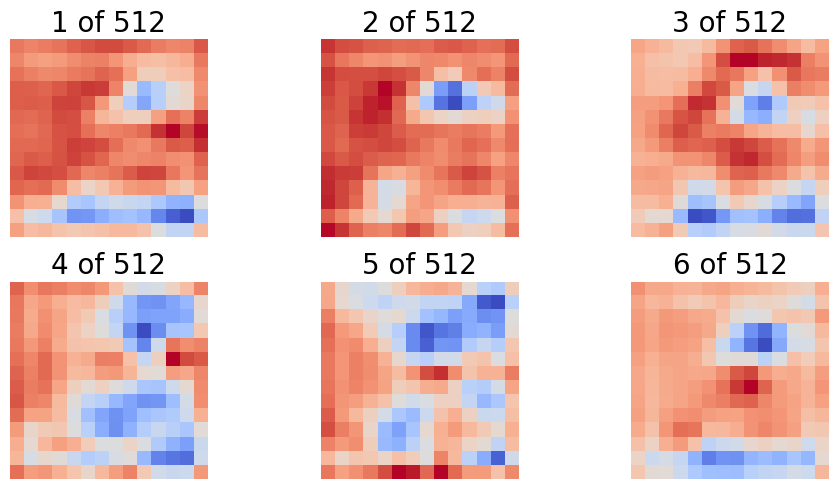

In [10]:
# Plot the activations
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
ax = ax.flatten()

for i, activation in enumerate(activations[0][0:6]):

    ax[i].imshow(activation, cmap="coolwarm")
    ax[i].set_title(f"{i+1} of {act_shape[0]}")
    ax[i].axis("off")

In [11]:
gradients = []

def save_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0].cpu().numpy().squeeze())

# Register the backward hook on a convolutional layer
hook = model.features[28].register_full_backward_hook(save_gradient)

# Forward pass
output = model(img_tensor)

# Pick the class with highest score
score = output[0].max()

# Backward pass from the score
score.backward()

# Remove the hook after use
hook.remove()

In [12]:
grad_shape = np.shape(gradients[0])
print(f"Shape of gradients: {grad_shape}") # (512, 14, 14)

Shape of gradients: (512, 14, 14)


Figure saved to /Users/conorosullivan/Documents/XAI/gradients.pdf


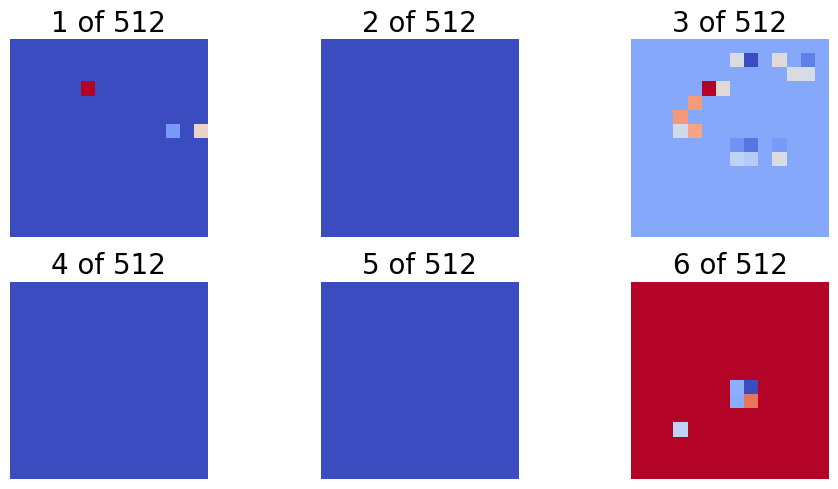

In [13]:
# Plot the activations
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
ax = ax.flatten()

for i, grad in enumerate(gradients[0][0:6]):

    ax[i].imshow(grad, cmap="coolwarm")
    ax[i].set_title(f"{i+1} of {grad_shape[0]}")
    ax[i].axis("off")

## Create Grad-CAM Heatmap

Figure saved to /Users/conorosullivan/Documents/XAI/gradients_histogram.pdf


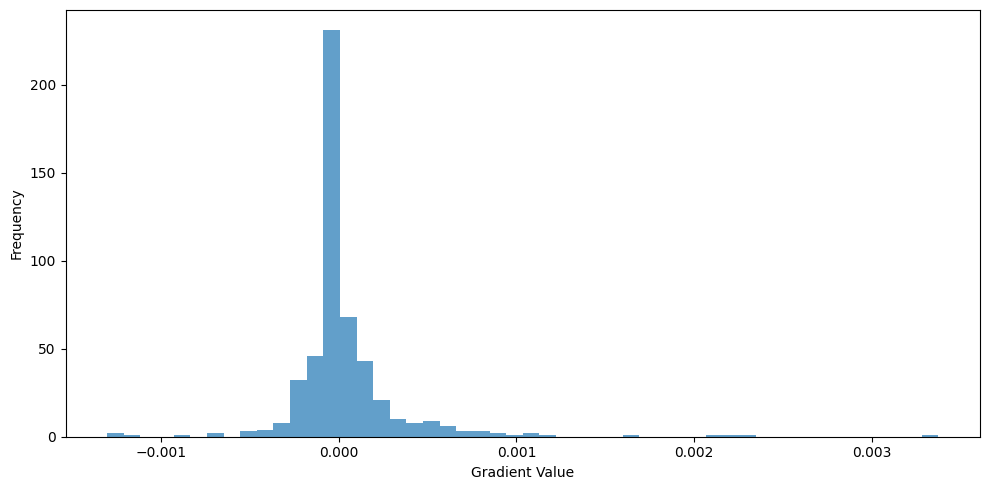

In [14]:
# Step 1: aggregate the gradients
gradients_aggregated = np.mean(gradients[0], axis=(1, 2))

# Histogram of aggregated gradients
plt.figure(figsize=(10, 5))
plt.hist(gradients_aggregated, bins=50, alpha=0.7)
plt.xlabel("Gradient Value")
plt.ylabel("Frequency")

vmin: -0.2280225157737732, vmax: 0.09764164686203003
Figure saved to /Users/conorosullivan/Documents/XAI/weighted_activations.pdf


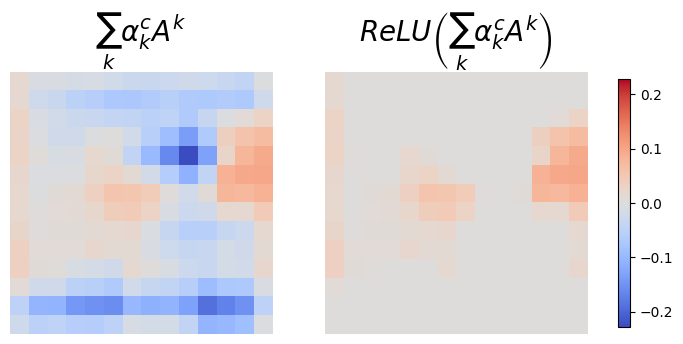

In [15]:
# Step 2: weight the activations by the aggregated gradients and sum them up
weighted_activations = np.sum(activations[0] *
                              gradients_aggregated[:, np.newaxis, np.newaxis],
                              axis=0)

# Step 3: ReLU summed activations
relu_weighted_activations = np.maximum(weighted_activations, 0)

# Find shared color range
vmin = weighted_activations.min()
vmax = weighted_activations.max()
print(f"vmin: {vmin}, vmax: {vmax}")
vmin = min(vmin,-vmax)
vmax = max(vmax,-vmin)

fig, ax = plt.subplots(1,2,figsize=(8, 8))

ax[0].imshow(weighted_activations, cmap="coolwarm", vmin=vmin, vmax=vmax)
ax[0].set_title(r"$\sum_k \alpha^c_k A^k$")
ax[0].axis("off")

ax[1].imshow(relu_weighted_activations, cmap="coolwarm", vmin=vmin, vmax=vmax)
ax[1].set_title(r"$ReLU\left(\sum_k \alpha^c_k A^k\right)$")
ax[1].axis("off")

# Add colorbar
plt.colorbar(ax[1].images[0], ax=ax, orientation='vertical', fraction=0.02, pad=0.05)

In [16]:
#Step 4: Upsample the heatmap to the original image size
upsampled_heatmap = cv2.resize(relu_weighted_activations,
                               (img_tensor.size(3), img_tensor.size(2)),
                               interpolation=cv2.INTER_LINEAR)

print(np.shape(upsampled_heatmap))  # Should be (224, 224)

(224, 224)


Figure saved to /Users/conorosullivan/Documents/XAI/heatmap.pdf


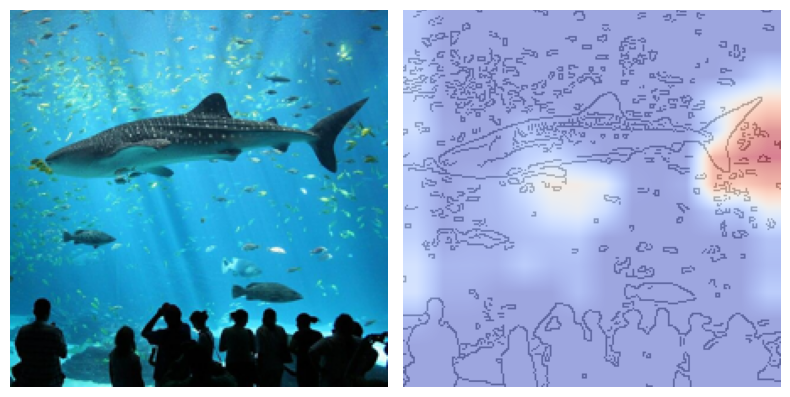

In [17]:
# Step 5: visualise the heatmap
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Input image
resized_img = img.resize((224, 224))
ax[0].imshow(resized_img)
ax[0].axis("off")

# Edge map for the input image
edge_img = cv2.Canny(np.array(resized_img), 100, 200)
ax[1].imshow(255-edge_img, alpha=0.5, cmap='gray')

# Overlay the heatmap
ax[1].imshow(upsampled_heatmap, alpha=0.5, cmap='coolwarm')
ax[1].axis("off")